## Figures for the report

Dataset collected 10/12/2025

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from model import wavelengths_nm, Database, populate_db
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline, interp1d
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import linregress


Load in data collected during the calibration run.

In [2]:
df = pd.read_csv('spectrum_data.csv', delimiter=',')
juices = list(df.Juice.unique())[1:]
blank = df.loc[df.Juice == 'Water'].iloc[:, :12].values.mean(axis=0)
blank_std = df.loc[df.Juice == 'Water'].iloc[:, :12].values.std(axis=0)

All datapoints collected

Text(0.5, 0, 'Wavelengths [nm]')

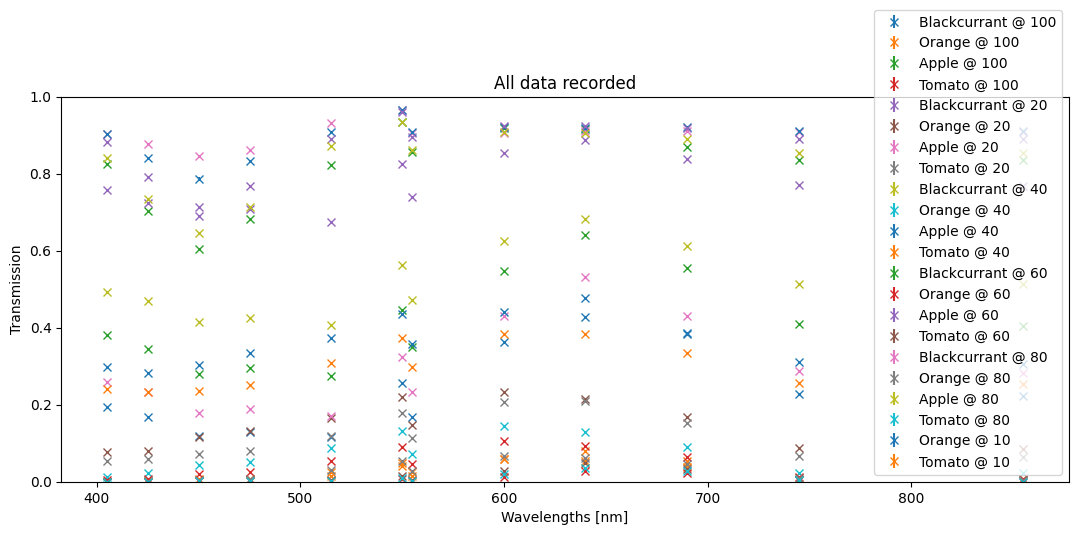

In [3]:
plt.figure(figsize=(13,5))

for c in df['Concentration [%]'].unique():
    for j in juices:
        values = df.loc[(df.Juice == j) & (df['Concentration [%]'] == c)].iloc[:, :12].values
        if len(values) > 0:
            mean = values.mean(axis=0)
            std = values.std(axis=0)
            mean = mean/blank
            std = std/blank

            plt.errorbar(wavelengths_nm, y=mean, yerr=std, label=f'{j} @ {c}', ls='', marker='x')

plt.title('All data recorded')
plt.ylim(0,1)
plt.ylabel('Transmission')
plt.legend()
plt.xlabel('Wavelengths [nm]')

Spectra of white LED

<ErrorbarContainer object of 3 artists>

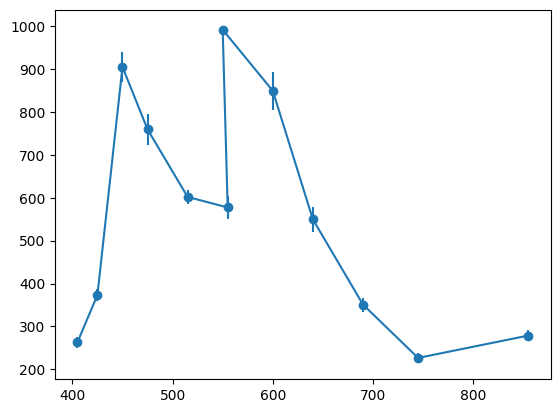

In [4]:
plt.scatter(wavelengths_nm, blank)
plt.errorbar(wavelengths_nm, blank, blank_std)

Looking at each of the absorbances

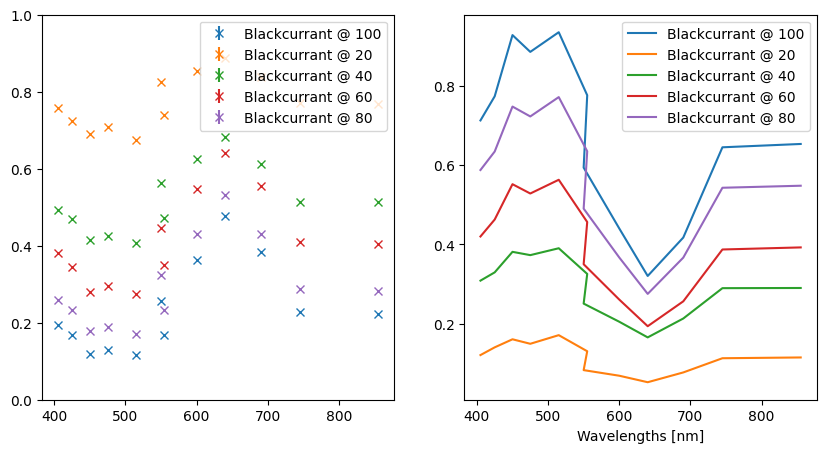

/var/folders/55/y8nplzr92z3002w35fdrm2wc0000gn/T/ipykernel_20327/176767721.py:16: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(wavelengths_nm, np.clip(-np.log10(mean), 0, 5), label=f'{j} @ {c}')


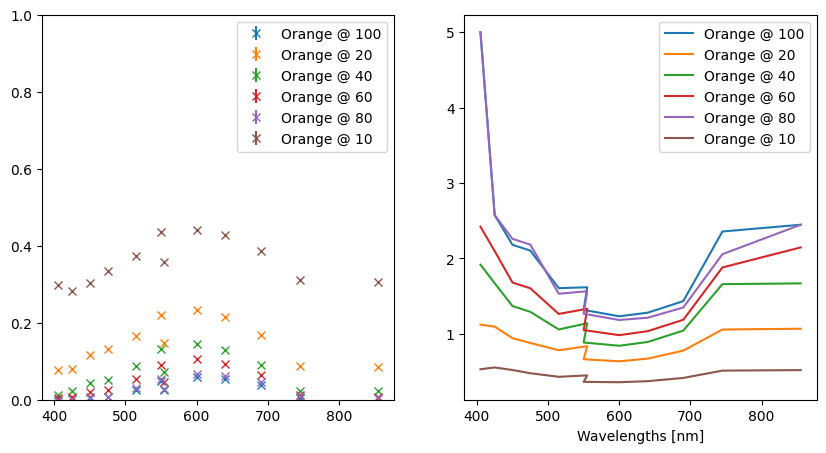

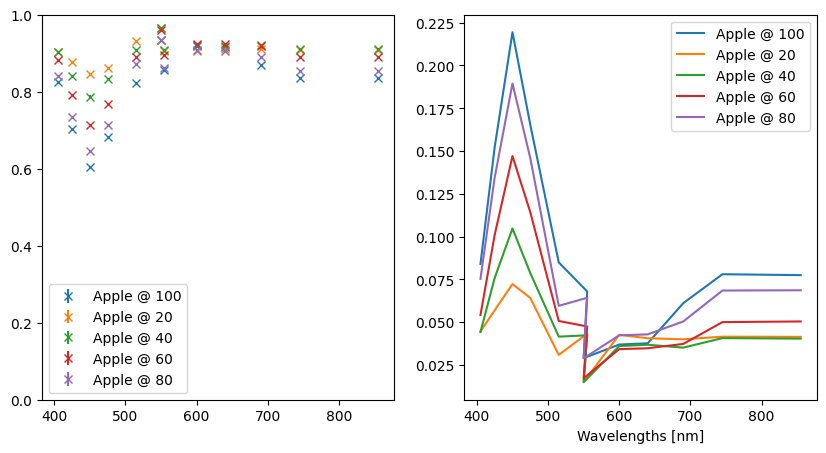

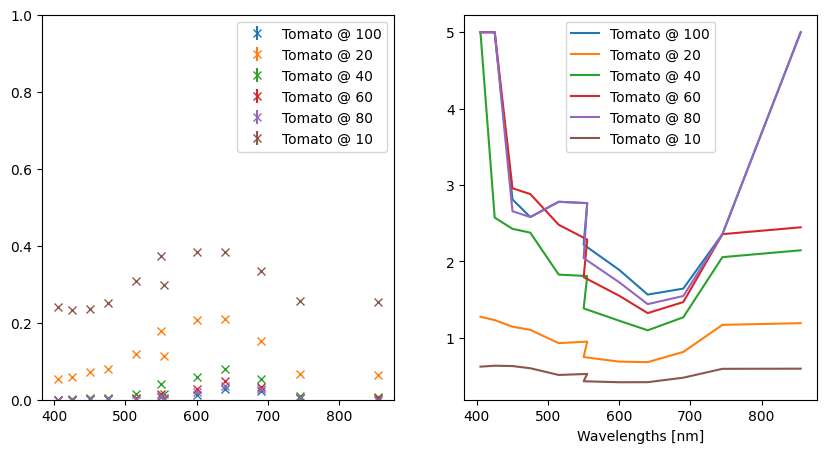

In [5]:
j = 'Tomato'
for j in juices:
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    sums = []
    for c in df['Concentration [%]'].unique():
        values = df.loc[(df.Juice == j) & (df['Concentration [%]'] == c)].iloc[:, :12].values
        if len(values) > 0:
            mean = values.mean(axis=0)
            std = values.std(axis=0)
            mean = mean/blank
            std = std/blank

            ax[0].errorbar(wavelengths_nm, y=mean, yerr=std, label=f'{j} @ {c}', ls='', marker='x')
            sums.append(mean.sum())

            ax[1].plot(wavelengths_nm, np.clip(-np.log10(mean), 0, 5), label=f'{j} @ {c}')

    ax[0].legend()
    ax[1].legend()
    ax[0].set_ylim(0,1)
    plt.xlabel('Wavelengths [nm]')
    plt.show()

Creation of an intermediate data dictionary.

In [6]:
from model import compute_data

juices, data = compute_data(df)

/Users/kenton/projects/spectrometer/model.py:72: RuntimeWarning: divide by zero encountered in divide
  yerr = np.clip(np.sqrt((0.5 / mean)**2 + (blank_std/blank)**2)/np.log(10), 0, 1)
/Users/kenton/projects/spectrometer/model.py:48: RuntimeWarning: divide by zero encountered in log10
  return np.clip(-np.log10(arr), 0, 5)


(0.0, 3.5)

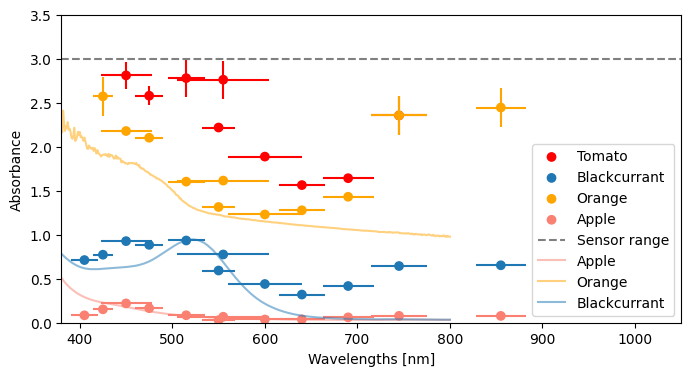

In [ ]:
c=100
# Filter
xerrs = np.array([30, 22, 55, 30, 40, 100, 35, 80, 50, 55, 60, 54])/2
yerr = np.clip(np.sqrt((0.5 / mean)**2 + (blank_std/blank)**2)/np.log(10), 0, 1)

# Plotting
plt.figure(figsize=(8,4))
# absorbance = np.clip(-np.log10(mean_norm), 0, 5)

plt.scatter(wavelengths_nm[2:-1], data['Tomato'][1][-1][2:-1], ls='', c='red', label='Tomato')
plt.errorbar(wavelengths_nm[2:-1], data['Tomato'][1][-1][2:-1], yerr = data['Tomato'][2][-1][2:-1], xerr=xerrs[2:-1],c='red',ls='')
plt.scatter(wavelengths_nm, data['Blackcurrant'][1][-1], ls='', c='tab:blue', label='Blackcurrant')
plt.errorbar(wavelengths_nm, data['Blackcurrant'][1][-1], yerr = data['Blackcurrant'][2][-1], xerr=xerrs,c='tab:blue',ls='')
plt.scatter(wavelengths_nm[1:], data['Orange'][1][-1][1:], ls='', c='orange', label='Orange')
plt.errorbar(wavelengths_nm[1:], data['Orange'][1][-1][1:], yerr = data['Orange'][2][-1][1:], xerr=xerrs[1:], c='orange',ls='')
plt.scatter(wavelengths_nm, data['Apple'][1][-1], ls='', c='salmon', label='Apple')
plt.errorbar(wavelengths_nm, data['Apple'][1][-1], yerr = data['Apple'][2][-1], xerr=xerrs, c='salmon',ls='')

plt.axhline(3, c='grey', label='Sensor range', ls='--')
plt.xlabel('Wavelengths [nm]')
plt.ylabel('Absorbance')
plt.legend()

# Plot UV-vis data alongside
wavelengths_uvvis = pd.read_csv('juices full conc.csv', skiprows=26).values[:,1:][:, 0]
identities = pd.read_csv('juices full conc.csv', skiprows=19).columns[1::2].values[[0,1,4]]
identities = ['Apple', 'Orange', 'Blackcurrant']
uv_vis_spectras = pd.read_csv('juices full conc.csv', skiprows=26).values[:,1:][:, 1::2][:, [0,1,4]]
uv_vis_colours = ['salmon', 'orange', 'tab:blue']

for i in range(3):
    plt.plot(wavelengths_uvvis, uv_vis_spectras[:,i]/2, label=identities[i], c = uv_vis_colours[i], alpha=0.5)
plt.xlabel('Wavelengths [nm]')
plt.legend()
plt.xlim(380, 1050)
plt.ylim(0, 3.5)

### Finding calibration curves

Blackcurrant LinregressResult(slope=np.float64(0.006300505198257342), intercept=np.float64(-0.02477988856891772), rvalue=np.float64(0.9964054016650142), pvalue=np.float64(0.00025856819580324486), stderr=np.float64(0.00030926318636671454), intercept_stderr=np.float64(0.020514199012962954))
Orange LinregressResult(slope=np.float64(0.010176405445924845), intercept=np.float64(0.3956322102892311), rvalue=np.float64(0.9674258038974003), pvalue=np.float64(0.001574335492069894), stderr=np.float64(0.0013314742561977067), intercept_stderr=np.float64(0.08080780042552711))
Apple LinregressResult(slope=np.float64(0.00020914991910332006), intercept=np.float64(0.008488918595560236), rvalue=np.float64(0.9072809374200688), pvalue=np.float64(0.03341590712703664), stderr=np.float64(5.596894718127303e-05), intercept_stderr=np.float64(0.0037125599542300425))
Tomato LinregressResult(slope=np.float64(0.020115041236953474), intercept=np.float64(0.3959253691254101), rvalue=np.float64(0.9731858174606114), pvalu

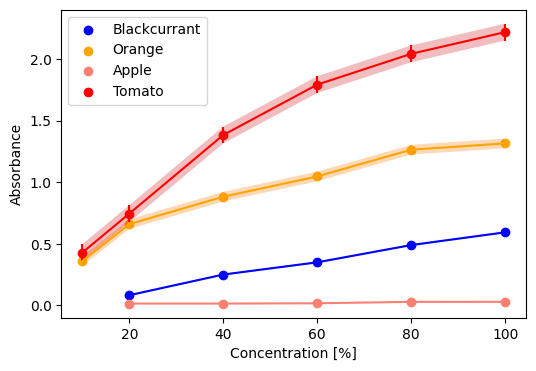

In [8]:


fig, ax = plt.subplots(figsize = (6,4), sharex=True)
colors = ['blue', 'orange', 'salmon', 'red']
labels = ['Blackcurrant', 'Orange', 'Apple', 'Tomato']

for i, j in enumerate(juices):
    concentrations, absorbance, yerr = data[j]
    w=6
    x,y = concentrations, absorbance[:,w]
    plt.scatter(x, y, label=f'{labels[i]}', c = colors[i])
    res = linregress(x,y)
    print(j, res)
    diff = np.abs(y - (res.slope*x+res.intercept)).mean()
    plt.errorbar(x, y, yerr= diff.mean()/2, ls='-', c = colors[i])
    
    plt.fill_between(x, y+ diff/2, y-(diff)/2, alpha=0.3)
    # plt.plot(x, res.slope*x-res.intercept)
    
    plt.xlabel('Concentration [%]')
    plt.legend()
plt.legend()
# plt.title(f'Calibration curves @ {wavelengths_nm[w]} nm')

plt.ylabel('Absorbance')
# plt.tight_layout()
# plt.ylim(0,0.2)

plt.show()

j
2.134895052995367
j
7.360933999755441
j
11.032723765923242
j
5.985500413203671


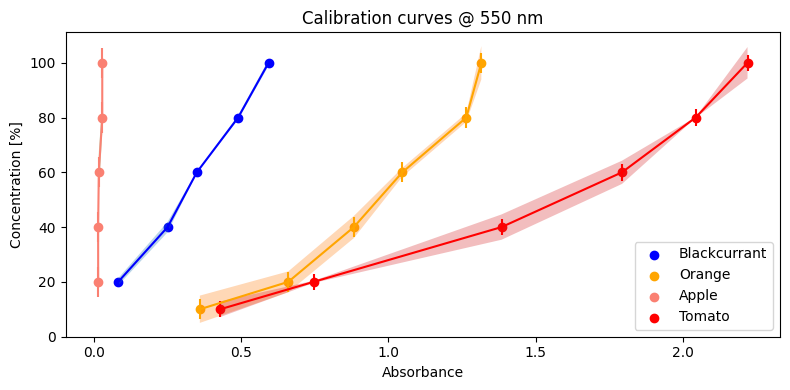

In [9]:
fig, ax = plt.subplots(figsize = (8,4), sharex=True)

colors = ['blue', 'orange', 'salmon', 'red']
for i, j in enumerate(juices):
    print('j')
    concentrations, absorbance, yerr = data[j]
    w=6
    x,y = concentrations, absorbance[:,w]
    plt.scatter(y, x, label=f'{j}', c = colors[i])

    res = linregress(y,x)
    diff = np.abs(x - (res.slope*y+res.intercept))
    print(diff.mean())
    plt.fill_between(y, x+ diff/2, x-(diff)/2, alpha=0.3)

    plt.errorbar(y, x, yerr= diff.mean()/2, ls='-', c = colors[i])

    # plt.fill_between(y, x+5 , x-5, alpha=0.3)
    plt.xlabel('Absorbance')

plt.legend()
plt.title(f'Calibration curves @ {wavelengths_nm[w]} nm')
plt.ylabel('Concentration [%]')
plt.tight_layout()
plt.show()

In [10]:
for i, j in enumerate(juices):

    concentrations, absorbance, yerr = data[j]
    diffs = []
    for w in range(3,12):
        x,y = concentrations, absorbance[:,w]
        res = linregress(y,x)
        diff = np.abs(x - (res.slope*y+res.intercept))
        diffs.append(diff.mean())
    print(diffs)
    print(j, np.array(diffs).mean()/2)

[np.float64(1.403982201031195), np.float64(1.228532913416607), np.float64(1.54257030898223), np.float64(2.134895052995367), np.float64(3.0649905685924805), np.float64(4.52788615820116), np.float64(4.4299468629364265), np.float64(2.4986416654952945), np.float64(2.2965473926742606)]
Blackcurrant 1.2848885069069456
[np.float64(6.639674301247875), np.float64(6.922818130290975), np.float64(8.328945295276965), np.float64(7.360933999755441), np.float64(7.38814373854231), np.float64(7.718592135550399), np.float64(8.903768400270318), np.float64(8.999083410275604), np.float64(8.748069883731125)]
Orange 3.9450016274967226
[np.float64(3.116051911873825), np.float64(6.08762544977956), np.float64(9.399562094167658), np.float64(11.032723765923242), np.float64(25.679160492683756), np.float64(24.01188611947263), np.float64(11.307713491557426), np.float64(6.957853121119854), np.float64(7.069471723008013)]
Apple 5.814558231643663
[np.float64(14.747921663291777), np.float64(7.8937955460808285), np.float64

Take uncertainty as the smallest interval (count).

Text(0.5, 1.0, 'Orange')

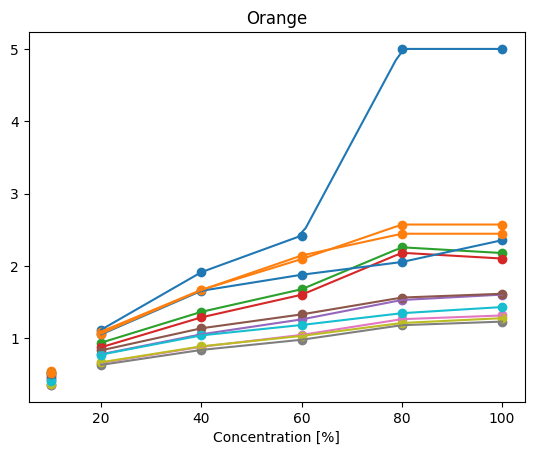

In [11]:

def synthesise_absorbance(splines, c):
    return np.array([s(c) for s in splines])

j = 'Orange'

splines = []
for w in range(len(wavelengths_nm)):
    concs = data[j][0]
    pts = [i[w] for i in data[j][1]]
    spline = CubicSpline(concs, pts)
    spline = lambda xnew: np.interp(xnew, concs, pts)

    plt.plot(np.linspace(20,100), spline(np.linspace(20,100)))
    plt.scatter(concs, pts)
    splines.append(spline)
    
    
plt.xlabel('Concentration [%]')
plt.title(j)

## Experiment 3

Load in repeat measurements

In [12]:
df_repeat = pd.read_csv('/Users/kenton/projects/spectrometer/20251214_spectrum_data.csv')
df_repeat['normalised'] = ((df_repeat.iloc[:, :12].values/df_repeat.iloc[-1, :12].values)).tolist()
df_repeat['absorbance'] = df_repeat['normalised'].apply(lambda x: np.clip(-np.log10(x), 0, 5))
df_repeat[df_repeat.Juice == 'Blackcurrant'].normalised

/var/folders/55/y8nplzr92z3002w35fdrm2wc0000gn/T/ipykernel_20327/977861439.py:3: RuntimeWarning: divide by zero encountered in log10
  df_repeat['absorbance'] = df_repeat['normalised'].apply(lambda x: np.clip(-np.log10(x), 0, 5))


0    [0.26587301587301587, 0.2265193370165746, 0.17...
1    [0.7420634920634921, 0.7375690607734806, 0.717...
2    [0.5357142857142857, 0.5082872928176796, 0.461...
3    [0.38492063492063494, 0.356353591160221, 0.300...
4    [0.27380952380952384, 0.24861878453038674, 0.1...
Name: normalised, dtype: object

In [13]:
def evaluate(db):
    gts = []
    preds = []

    for idx, row in df_repeat.iloc[:-1].iterrows():
        conc = row['Concentration [%]']
        gts.append((row.Juice, conc))
        vec = row.absorbance
        preds.append(db.search(vec))
    return gts, preds

def get_metrics(gts, preds):
    labels= ['Blackcurrant', 'Orange', 'Apple', 'Tomato']
    gt_classes = [i[0] for i in gts]
    preds_classes = [i[0] for i in preds]
    gt_concs = np.array([i[1] for i in gts])
    preds_concs = np.array([i[1] for i in preds])
    print(classification_report(gt_classes, preds_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix(gt_classes, preds_classes, labels=juices), 
                                display_labels=labels)
    disp.plot()
    
    return np.mean(np.abs(gt_concs - preds_concs)), np.std(np.abs(gt_concs - preds_concs))



TM

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00         5
Blackcurrant       1.00      1.00      1.00         5
      Orange       0.71      0.83      0.77         6
      Tomato       0.80      0.67      0.73         6

    accuracy                           0.86        22
   macro avg       0.88      0.88      0.87        22
weighted avg       0.87      0.86      0.86        22



(np.float64(11.727272727272727), np.float64(11.820366930859857))

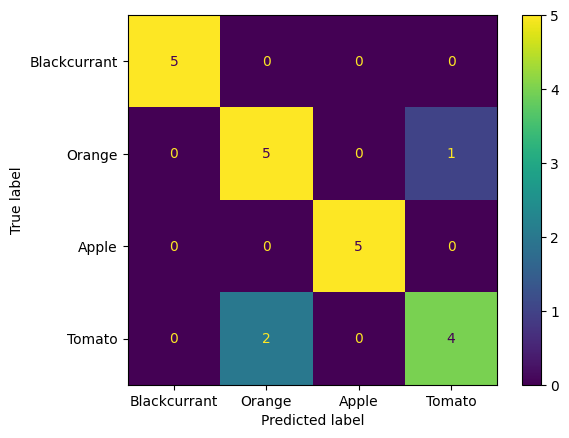

In [14]:
db = Database()
db = populate_db(juices, db, data)  
gts, preds = evaluate(db)
get_metrics(gts, preds)

TM + Exclusion + Spline

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00         5
Blackcurrant       1.00      1.00      1.00         5
      Orange       1.00      0.83      0.91         6
      Tomato       0.86      1.00      0.92         6

    accuracy                           0.95        22
   macro avg       0.96      0.96      0.96        22
weighted avg       0.96      0.95      0.95        22



(np.float64(8.931818181818182), np.float64(9.234686900418462))

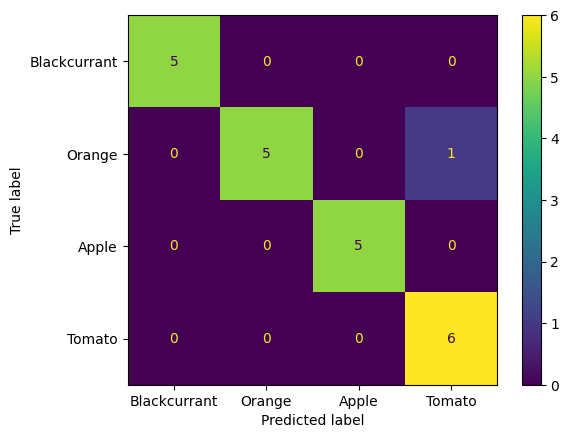

In [15]:
db2 = Database(limit=2, limit_end=-1)
db2 = populate_db(juices, db2, data)  
gts, preds = evaluate(db2)
get_metrics(gts, preds)

TM + Spline + Exclusion

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00         5
Blackcurrant       1.00      1.00      1.00         5
      Orange       1.00      0.83      0.91         6
      Tomato       0.86      1.00      0.92         6

    accuracy                           0.95        22
   macro avg       0.96      0.96      0.96        22
weighted avg       0.96      0.95      0.95        22



(np.float64(9.5), np.float64(9.787515238580962))

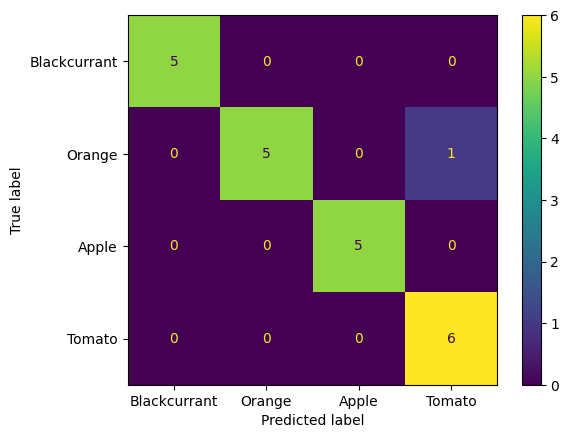

In [16]:
db3 = Database(limit=2, limit_end=-1, )
db3 = populate_db(juices, db3,data, mode='interp')  
gts, preds = evaluate(db3)
get_metrics(gts, preds)

In [17]:
gts = []
preds = []

for j in juices:
    splines = []
    # Prepare splines
    for w in range(len(wavelengths_nm)):
        if w < 2 or w>10:
            continue
        concs = data[j][0]
        pts = [i[w] for i in data[j][1]]

        idxs = np.argsort(pts)
        pts = np.array(pts)[idxs]
        concs = np.array(concs)[idxs]
        spline = interp1d(pts, concs, bounds_error=False, fill_value = (concs.min(),concs.max()))
        splines.append(spline)

    for idx, row in df_repeat[df_repeat.Juice == j].iterrows():
        idx = 0
        concs_retrieved = []
        print(j, row['Concentration [%]'])
        for w in range(len(wavelengths_nm)):
            if w < 2 or w>10:
                continue
            concs_retrieved.append(np.clip(splines[idx](row.absorbance[w]), 0, 100))
            idx += 1
        print('Predicted: ', np.array(concs_retrieved).mean(), 'Std Dev: ', np.array(concs_retrieved).std(), )
        gts.append(row['Concentration [%]'])
        preds.append(np.array(concs_retrieved).mean())

        print('Mean Absolute Error:', np.abs(np.array(concs_retrieved).mean()-row['Concentration [%]']))

gts = np.array(gts)
preds = np.array(preds)

print(np.mean(np.abs(gts-preds)), np.std(np.abs(gts-preds)))


Blackcurrant 100
Predicted:  77.43516381504583 Std Dev:  4.208027605145415
Mean Absolute Error: 22.564836184954174
Blackcurrant 20
Predicted:  21.085220295500392 Std Dev:  0.9786757883007828
Mean Absolute Error: 1.0852202955003918
Blackcurrant 40
Predicted:  36.09700498107353 Std Dev:  0.7513889772799892
Mean Absolute Error: 3.902995018926468
Blackcurrant 60
Predicted:  59.04708753308176 Std Dev:  2.160536600984146
Mean Absolute Error: 0.9529124669182423
Blackcurrant 80
Predicted:  76.54235267546878 Std Dev:  1.077031251424552
Mean Absolute Error: 3.457647324531223
Orange 10
Predicted:  11.603651146952139 Std Dev:  0.21971403483615823
Mean Absolute Error: 1.6036511469521386
Orange 20
Predicted:  22.633708907431114 Std Dev:  1.3985227338705062
Mean Absolute Error: 2.6337089074311137
Orange 40
Predicted:  60.455841723456814 Std Dev:  6.800562662857286
Mean Absolute Error: 20.455841723456814
Orange 60
Predicted:  85.25525700543989 Std Dev:  5.954702930219537
Mean Absolute Error: 25.255257

Inspection of templates and measurements

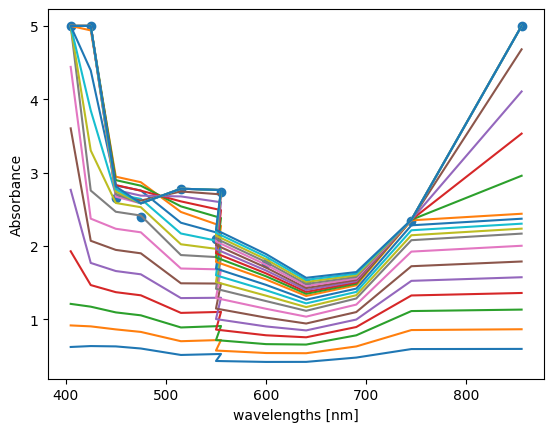

In [18]:
from scipy.interpolate import interp1d

mode= 'it'
templates = []
targets = []
j = juices[-1]
splines = []

for w in range(len(wavelengths_nm)):
    concs = data[j][0]
    pts = [i[w] for i in data[j][1]]
    if mode == 'spline':
        spline = CubicSpline(concs, pts)
    else:
        spline = interp1d(concs, pts)
    splines.append(spline)

for idx, conc in enumerate(np.linspace(data[j][0].min(), data[j][0].max(), 21)):
    t = synthesise_absorbance(splines, conc)
    templates.append(t)
    targets.append((j,conc))
    db.add(t, (j,conc))
    plt.plot(wavelengths_nm, t, label=f'{j,conc}')

plt.xlabel('wavelengths [nm]')
plt.ylabel('Absorbance')
plt.scatter(wavelengths_nm, row.absorbance)